In [1]:
from IPython.display import IFrame
IFrame(src="https://www.youtube.com/embed/TUFovZsBcW4", width=1920/4, height=1080/4)
#<iframe width="560" height="315" src="https://www.youtube.com/embed/TUFovZsBcW4" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [ ]:
# See above video for theoretical info

In [2]:
from IPython.display import IFrame
IFrame(src="https://www.youtube.com/embed/uvBauYQYVNg", width=1920/4, height=1080/4)
#<iframe width="560" height="315" src="https://www.youtube.com/embed/uvBauYQYVNg" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [1]:
from qiskit import IBMQ, Aer, transpile, schedule as build_schedule
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes.calibration import RZXCalibrationBuilderNoEcho
from qiskit_nature.drivers import Molecule # containerises the molecule
from qiskit_nature.drivers.second_quantization import ElectronicStructureDriverType, ElectronicStructureMoleculeDriver
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem # as opposed to vibrational or protein problems
from qiskit_nature.converters.second_quantization import QubitConverter # map fermionic operators to qubits
from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer # reduce problem size, work with electronic Hamiltonian
from qiskit_nature.operators.second_quantization import FermionicOp
from qiskit_nature.mappers.second_quantization import ParityMapper
from qiskit_nature.algorithms import GroundStateEigensolver
from qiskit.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.utils import QuantumInstance
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
IBMQ.load_account()
provider = IBMQ.get_provider()
qcomp = provider.get_backend('ibmq_manila')
for backend in provider.backends():
    print(backend.name())

In [4]:
def HEA_naive(num_q, depth):
    # Hardware-efficient ansatz
    # entanglers are CNOTs
    circuit = QuantumCircuit(num_q)
    params = ParameterVector("theta", length=num_q * (3 * depth + 2))
    counter = 0
    for q in range(num_q):
        # No rz, it's on the 0 state
        circuit.rx(params[counter], q)
        counter += 1 
        circuit.rz(params[counter], q)
        counter += 1
    for d in range(depth):
        # entangling and single-qubit rotations
        for q in range(num_q - 1):
            circuit.cx(q, q + 1)
        for q in range(num_q):
            circuit.rz(params[counter], q)
            counter += 1
            circuit.rx(params[counter], q)
            counter += 1 
            circuit.rz(params[counter], q)
            counter += 1
    return circuit, params

In [5]:
def HEA_aware(num_q, depth, hardware):
    circuit = QuantumCircuit(num_q)
    params = ParameterVector("theta", length=num_q * (3 * depth + 2))
    counter = 0
    for q in range(num_q):
        circuit.rx(params[counter], q)
        counter += 1 
        circuit.rz(params[counter], q)
        counter += 1
    for d in range(depth):
        for q in range(num_q - 1):
            gate = QuantumCircuit(num_q)
            # Cross-resonant gate
            gate.rzx(np.pi/2, q, q + 1)
            # builds as if on hardware
            pass_ = RZXCalibrationBuilderNoEcho(hardware)
            qc_cr = PassManager(pass_).run(gate)
            circuit.compose(qc_cr, inplace=True)
        for q in range(num_q):
            circuit.rz(params[counter], q)
            counter += 1
            circuit.rx(params[counter], q)
            counter += 1 
            circuit.rz(params[counter], q)
            counter += 1
    return circuit, params

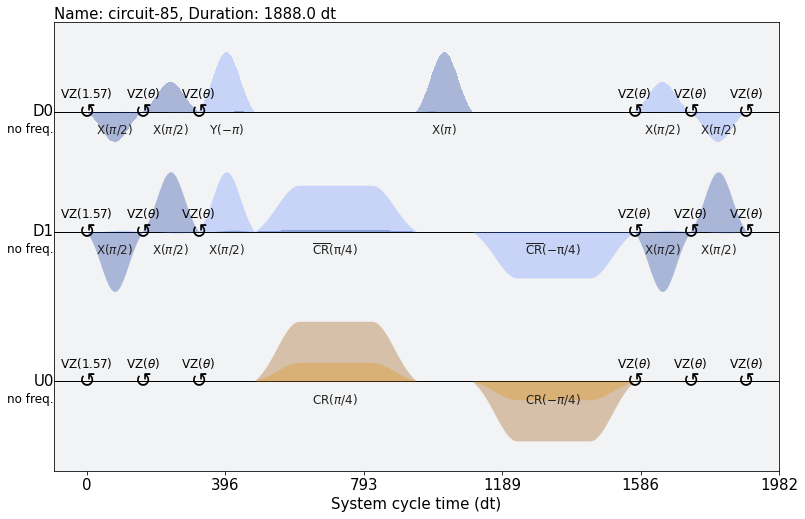

In [6]:
# Hydrogen (H2)
depth = 1
qubits = 2
back = qcomp
circuit, _ = HEA_naive(qubits, depth)
t = transpile(circuit, back)
schedule = build_schedule(t, back)
schedule.draw()

In [ ]:
#circuit, _ = HEA_aware(qubits, depth, qcomp)
#t = transpile(circuit, back)
#schedule = build_schedule(t, back)
#schedule.draw()

# requires pulse-enabled backend

In [7]:
qubit_converter = QubitConverter(ParityMapper(), two_qubit_reduction=True)
# two_qubit_reduction=True allows exploiting of symmetry in the problem
numpy_solver = NumPyMinimumEigensolver()

In [8]:
spsa = SPSA(100) # optimiser
# Shot noise, but no depolarising or decoherence noise
qi = QuantumInstance(Aer.get_backend('aer_simulator'))
vqe_circuit = VQE(ansatz=circuit, quantum_instance=qi, optimizer=spsa)

In [9]:
# H2 simulation
total_dist = 4
dist = 0.1
incr_early = 0.1 #ångströms
incr_late = 0.3

real_energies = []
vqe_energies = []
dists = []
while dist < total_dist:
    print(dist, total_dist)
    molecule = Molecule(geometry=[['H', [0., 0., 0.]], ['H', [0., 0., dist]]])
    # each H in same x&y coordinates, difference of bond length
    driver = ElectronicStructureMoleculeDriver(molecule, basis='sto3g',
                                               driver_type=ElectronicStructureDriverType.PYSCF)
    # Slater-type orbital 3 Gaussian, very common for VQE
    # one function approximating each orbital
    # there are more accurate basis functions
    # pyscf to solve hamiltonian integrals
    es_problem = ElectronicStructureProblem(driver)
    second_q_ops = es_problem.second_q_ops()    
    
    if dist == 0.1:
        FermionicOp.set_truncation(0)
        print(second_q_ops[0])
        FermionicOp.set_truncation(1)
        print(qubit_converter.convert(second_q_ops[0], num_particles=es_problem.num_particles))
        print(es_problem.grouped_property)
        
    # compares numpy to vqe
    calc = GroundStateEigensolver(qubit_converter, numpy_solver)
    res = calc.solve(es_problem)
    real_energies.append(np.real(res.total_energies[0]))

    calc = GroundStateEigensolver(qubit_converter, vqe_circuit)
    res = calc.solve(es_problem)
    vqe_energies.append(np.real(res.total_energies[0]))
    
    dists.append(dist)
    if dist > total_dist / 2:
        dist += incr_late
    else:
        dist += incr_early

0.1 4
Fermionic Operator
register length=4, number terms=36
  -1.6738851560973642 * ( +_0 -_0 )
+ 0.36054478973023163 * ( +_1 -_1 )
+ -1.6738851560973642 * ( +_2 -_2 )
+ 0.36054478973023163 * ( +_3 -_3 )
+ -0.38594279814374044 * ( +_0 +_0 -_0 -_0 )
+ -0.07808512954863728 * ( +_0 +_1 -_1 -_0 )
+ -0.07808512954863148 * ( +_0 +_0 -_1 -_1 )
+ -0.3821758498854658 * ( +_0 +_1 -_0 -_1 )
+ -0.38594279814374044 * ( +_0 +_2 -_0 -_2 )
+ -0.07808512954863728 * ( +_0 +_3 -_1 -_2 )
+ -0.07808512954863148 * ( +_0 +_2 -_1 -_3 )
+ -0.3821758498854658 * ( +_0 +_3 -_0 -_3 )
+ -0.38217584988546094 * ( +_1 +_0 -_1 -_0 )
+ -0.07808512954863726 * ( +_1 +_1 -_0 -_0 )
+ -0.07808512954863148 * ( +_1 +_0 -_0 -_1 )
+ -0.4061422200009709 * ( +_1 +_1 -_1 -_1 )
+ -0.38217584988546094 * ( +_1 +_2 -_1 -_2 )
+ -0.07808512954863726 * ( +_1 +_3 -_0 -_2 )
+ -0.07808512954863148 * ( +_1 +_2 -_0 -_3 )
+ -0.4061422200009709 * ( +_1 +_3 -_1 -_3 )
+ -0.38594279814374044 * ( +_2 +_0 -_2 -_0 )
+ -0.07808512954863728 * ( +_2 +_1 

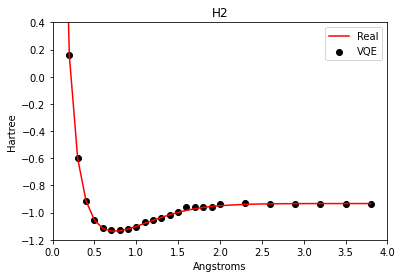

In [10]:
plt.plot(dists, real_energies, label='Real', color='red')
plt.scatter(dists, vqe_energies, label='VQE', color='black')
plt.title("H2")
plt.ylim(-1.2, 0.4)
plt.xlim(0, 4)
plt.xlabel('Angstroms')
plt.ylabel('Hartree')
plt.legend()
plt.show()

In [ ]:
# Lennard-Jones potential

In [ ]:
depth = 2
qubits = 4
circuit, _ = HEA_naive(qubits, depth)
spsa = SPSA(100)
qi = QuantumInstance(Aer.get_backend('aer_simulator'))
vqe_circuit = VQE(ansatz=circuit, quantum_instance=qi, optimizer=spsa)
#print(circuit)

In [12]:
total_dist = 5
dist = 0.3
incr_early = 0.1
incr_late = 0.3

real_energies = []
vqe_energies = []
dists = []
while dist < total_dist:
    print(dist, total_dist)
    molecule = Molecule(geometry=[['Li', [0., 0., 0.]], ['H', [0., 0., dist]]])
    driver = ElectronicStructureMoleculeDriver(molecule, basis='sto3g', 
                                               driver_type=ElectronicStructureDriverType.PYSCF)
    transformer = FreezeCoreTransformer(freeze_core=True, remove_orbitals=[3, 4])
    # freeze_core=True: assumes (1s) inner electrons of Li don't influence bond much
    # remove_orbitals=[3, 4]: 2py and 2pz
    # we care about 2px because it's orthogonal to bond
    es_problem = ElectronicStructureProblem(driver, transformers=[transformer])
    second_q_ops = es_problem.second_q_ops()    

    if dist == 0.3:
        print(second_q_ops[0])
        print(qubit_converter.convert(second_q_ops[0], num_particles=es_problem.num_particles))
        print(es_problem.grouped_property)    
        print(es_problem.grouped_property_transformed)

    calc = GroundStateEigensolver(qubit_converter, numpy_solver)
    res = calc.solve(es_problem)
    real_energies.append(np.real(res.total_energies[0]))

    calc = GroundStateEigensolver(qubit_converter, vqe_circuit) #VQEClient()
    res = calc.solve(es_problem)
    vqe_energies.append(np.real(res.total_energies[0]))
    
    dists.append(dist)
    if dist > total_dist / 2:
        dist += incr_late
    else:
        dist += incr_early

0.3 5
Fermionic Operator
register length=6, number terms=342
  -0.6036995203445122 * ( +_0 -_0 )
+ -0.03997534699734338 * ( +_0 -_1 )
+ -0.060629288199771536 * ( +_0 -_2 )
+ -0.03997534699734337 * ( +_1 -_0 )
+ -0.5052997654649872 * ( +_1 -_1 )
+ -0.0495673816955102 * ( +_1 -_2 )
+ -0.06062928819977166 * ( +_2 -_0 )
+ -0.0495673816955102 * ( +_2 -_1 )
+ 0.24164264046032496 * ( +_2 -_2 )
+ -0.6036995203445122 * ( +_3 -_3 )
+ -0.03997534699734338 * ( +_3 -_4 )
+ -0.060629288199771536 * ( +_3 -_5 )
+ -0.03997534699734337 * ( +_4 -_3 )
+ -0.5052997654649872 * ( +_4 -_4 )
+ -0.0495673816955102 * ( +_4 -_5 )
+ -0.06062928819977166 * ( +_5 -_3 )
+ -0.0495673816955102 * ( +_5 -_4 )
+ 0.24164264046032496 * ( +_5 -_5 )
+ -0.1606656450394617 * ( +_0 +_0 -_0 -_0 )
+ -0.019987681919176332 * ( +_0 +_0 -_1 -_0 )
+ -0.030314642231500127 * ( +_0 +_0 -_2 -_0 )
+ -0.019987681919176326 * ( +_0 +_1 -_0 -_0 )
+ -0.023745950405479905 * ( +_0 +_1 -_1 -_0 )
+ -0.0049551524290925115 * ( +_0 +_1 -_2 -_0 )
+ -0.0

0.4 5
0.5 5
0.6 5
0.7 5
0.7999999999999999 5
0.8999999999999999 5
0.9999999999999999 5
1.0999999999999999 5
1.2 5
1.3 5
1.4000000000000001 5
1.5000000000000002 5
1.6000000000000003 5
1.7000000000000004 5
1.8000000000000005 5
1.9000000000000006 5
2.0000000000000004 5
2.1000000000000005 5
2.2000000000000006 5
2.3000000000000007 5
2.400000000000001 5
2.500000000000001 5
2.8000000000000007 5
3.1000000000000005 5
3.4000000000000004 5
3.7 5
4.0 5
4.3 5
4.6 5
4.8999999999999995 5


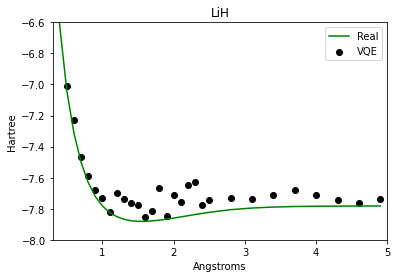

In [13]:
plt.plot(dists, real_energies, label='Real', color='green')
plt.scatter(dists, vqe_energies, label='VQE', color='black')
plt.title("LiH")
plt.ylim(-8, -6.6)
plt.xlim(0.3, 5)
plt.xlabel('Angstroms')
plt.ylabel('Hartree')
plt.legend()
plt.show()
# Depth required for chemical accuracy around 8 for LiH
# around 28 for BeH2

In [16]:
depth = 2
qubits = 6
circuit, _ = HEA_naive(qubits, depth)
spsa = SPSA(100)
qi = QuantumInstance(Aer.get_backend('aer_simulator'))
vqe_circuit = VQE(ansatz=circuit, quantum_instance=qi, optimizer=spsa)
print(circuit)

      ┌──────────────┐ ┌──────────────┐     ┌───────────────┐┌───────────────┐»
q_0: ─┤ Rx(theta[0]) ├─┤ Rz(theta[1]) ├──■──┤ Rz(theta[12]) ├┤ Rx(theta[13]) ├»
      ├──────────────┤ ├──────────────┤┌─┴─┐└───────────────┘├───────────────┤»
q_1: ─┤ Rx(theta[2]) ├─┤ Rz(theta[3]) ├┤ X ├────────■────────┤ Rz(theta[15]) ├»
      ├──────────────┤ ├──────────────┤└───┘      ┌─┴─┐      └───────────────┘»
q_2: ─┤ Rx(theta[4]) ├─┤ Rz(theta[5]) ├───────────┤ X ├──────────────■────────»
      ├──────────────┤ ├──────────────┤           └───┘            ┌─┴─┐      »
q_3: ─┤ Rx(theta[6]) ├─┤ Rz(theta[7]) ├────────────────────────────┤ X ├──────»
      ├──────────────┤ ├──────────────┤                            └───┘      »
q_4: ─┤ Rx(theta[8]) ├─┤ Rz(theta[9]) ├───────────────────────────────────────»
     ┌┴──────────────┤┌┴──────────────┤                                       »
q_5: ┤ Rx(theta[10]) ├┤ Rz(theta[11]) ├───────────────────────────────────────»
     └───────────────┘└───────────────┘ 

In [17]:
total_dist = 5
dist = 0.4
incr_early = 0.2
incr_late = 0.4

real_energies = []
vqe_energies = []
dists = []
while dist < total_dist:
    print(dist, total_dist)
    molecule = Molecule(geometry=[['H', [0., 0., -dist]], ['Be', [0., 0., 0.]], ['H', [0., 0., dist]]])
    driver = ElectronicStructureMoleculeDriver(molecule, basis='sto3g', 
                                               driver_type=ElectronicStructureDriverType.PYSCF)

    transformer = FreezeCoreTransformer(freeze_core=True, remove_orbitals=[4, 5])
    es_problem = ElectronicStructureProblem(driver, transformers=[transformer])
    second_q_ops = es_problem.second_q_ops()    

    if dist == 0.4:
        print(second_q_ops[0])
        print(qubit_converter.convert(second_q_ops[0], num_particles=es_problem.num_particles))
        print(es_problem.grouped_property)    
        print(es_problem.grouped_property_transformed)

    calc = GroundStateEigensolver(qubit_converter, numpy_solver)
    res = calc.solve(es_problem)
    real_energies.append(np.real(res.total_energies[0]))

    calc = GroundStateEigensolver(qubit_converter, vqe_circuit)
    res = calc.solve(es_problem)
    vqe_energies.append(np.real(res.total_energies[0]))
    
    dists.append(dist)
    if dist > total_dist / 2:
        dist += incr_late
    else:
        dist += incr_early

0.4 5
Fermionic Operator
register length=8, number terms=300
  -2.1836987702177213 * ( +_0 -_0 )
+ -1.807590064012285 * ( +_1 -_1 )
+ 0.3170758241143785 * ( +_1 -_3 )
+ -1.566459961769854 * ( +_2 -_2 )
+ 0.31707582411437835 * ( +_3 -_1 )
+ -0.7704516402910335 * ( +_3 -_3 )
+ -2.1836987702177213 * ( +_4 -_4 )
+ -1.807590064012285 * ( +_5 -_5 )
+ 0.3170758241143785 * ( +_5 -_7 )
+ -1.566459961769854 * ( +_6 -_6 )
+ 0.31707582411437835 * ( +_7 -_5 )
+ -0.7704516402910335 * ( +_7 -_7 )
+ -0.32818677742479396 * ( +_0 +_0 -_0 -_0 )
+ -0.05127857038715382 * ( +_0 +_1 -_1 -_0 )
+ 0.046462901147835654 * ( +_0 +_1 -_3 -_0 )
+ -0.010666728252072426 * ( +_0 +_2 -_2 -_0 )
+ 0.04646290114783609 * ( +_0 +_3 -_1 -_0 )
+ -0.06253979118853405 * ( +_0 +_3 -_3 -_0 )
+ -0.051278570387153846 * ( +_0 +_0 -_1 -_1 )
+ 0.04646290114783555 * ( +_0 +_0 -_3 -_1 )
+ -0.25073346595951496 * ( +_0 +_1 -_0 -_1 )
+ 0.07902542581735342 * ( +_0 +_3 -_0 -_1 )
+ -0.010666728252072433 * ( +_0 +_0 -_2 -_2 )
+ -0.2289623786669

0.6000000000000001 5
0.8 5
1.0 5
1.2 5
1.4 5
1.5999999999999999 5
1.7999999999999998 5
1.9999999999999998 5
2.1999999999999997 5
2.4 5
2.6 5
3.0 5
3.4 5
3.8 5
4.2 5
4.6000000000000005 5


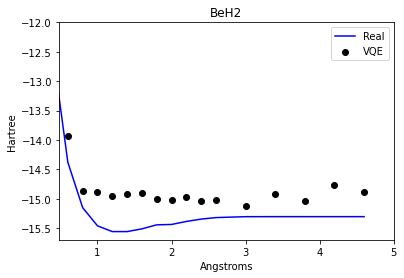

In [18]:
plt.plot(dists, real_energies, label='Real', color='blue')
plt.scatter(dists, vqe_energies, label='VQE', color='black')
plt.title("BeH2")
plt.ylim(-15.7, -12.0)
plt.xlim(0.48, 5)
plt.xlabel('Angstroms')
plt.ylabel('Hartree')
plt.legend()
plt.show()

In [3]:
from qiskit.tools.jupyter import *
%qiskit_version_table